# Install packages

In [1]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install pystac_client odc.stac rioxarray hvplot geoviews jupyter_bokeh folium dask jupyter-server-proxy geocube xarray_spatial


# Import packages

In [2]:
import os
import matplotlib.pyplot as plt
import pystac_client
from odc.stac import stac_load
import xarray as xr
import rioxarray as rxr
import hvplot.xarray
import rasterio as rio
from rasterio.plot import show
import requests
from PIL import Image
from io import BytesIO
from pprint import pprint
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import json
from geocube.api.core import make_geocube
from xrspatial import zonal_stats


/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 314, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


# Setup dask cluster

In [3]:
from dask.distributed import Client, progress
client = Client()  # set up local cluster on the machine
client

INFO:distributed.scheduler:State start
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/scheduler-bkvcpcuy', purging
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:45569
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44235'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39315'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:34537 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:34537
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:49082
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:40875 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:40875
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:49092
INFO:distributed.sche

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 12.67 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45569,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 12.67 GiB
Comm: tcp://127.0.0.1:34537,Total threads: 1
Dashboard: http://127.0.0.1:38435/status,Memory: 6.34 GiB
Nanny: tcp://127.0.0.1:44235,


# Search and load Sentinel-2 scenes on AWS (use Element84 search endpoint) using STAC API

In [4]:
longitude = 6.858316179422616
latitude = 50.7237273657193

In [5]:
catalog = pystac_client.Client.open(
    'https://earth-search.aws.element84.com/v1')

# Define a small bounding box around the chosen point
km2deg = 1.0 / 111
x, y = (longitude, latitude)
r = 1 * km2deg  # radius in degrees
bbox = (x - r, y - r, x + r, y + r)

search = catalog.search(
    collections=['sentinel-2-c1-l2a'],
    bbox=bbox,
    datetime='2024-06-01/2024-08-31',
    query={'eo:cloud_cover': {'lt': 30}},
)
items = search.item_collection()

In [6]:
len(items)

23

In [7]:
items[0]

<Item id=S2A_T31UGS_20240831T103023_L2A>

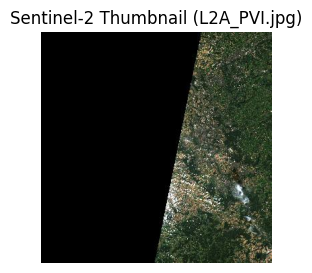

In [8]:
thumbnail_url = "https://e84-earth-search-sentinel-data.s3.us-west-2.amazonaws.com/sentinel-2-c1-l2a/31/U/GS/2024/8/S2A_T31UGS_20240831T103023_L2A/L2A_PVI.jpg"

response = requests.get(thumbnail_url)
img = Image.open(BytesIO(response.content))

fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(img)
ax.axis('off')
ax.set_title("Sentinel-2 Thumbnail (L2A_PVI.jpg)")
plt.show()

## Test reading and visualizing one geotiff asset

In [9]:
url = "https://e84-earth-search-sentinel-data.s3.us-west-2.amazonaws.com/sentinel-2-c1-l2a/31/U/GS/2024/8/S2A_T31UGS_20240831T103023_L2A/B8A.tif"

with rio.open(f'/vsicurl/{url}') as src:
    pprint(src.profile)

{'blockxsize': 512,
 'blockysize': 512,
 'compress': 'deflate',
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 31N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32631"]]'),
 'driver': 'GTiff',
 'dtype': 'uint16',
 'height': 5490,
 'interleave': 'band',
 'nodata': 0.0,
 'tiled': True,
 'transform': Affine(20.0, 0.0, 699960.0,
       0.0, -20.0, 5700000.0),
 'width': 5490}


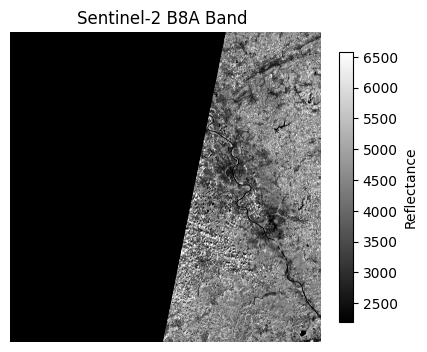

In [10]:
with rio.open(f'/vsicurl/{url}') as src:
    band = src.read(1)
    vmin, vmax = np.percentile(band[band > 0], (2, 98))
    fig, ax = plt.subplots(figsize=(5, 5))
    img = ax.imshow(band, cmap='gray', vmin=vmin, vmax=vmax)
    ax.set_title("Sentinel-2 B8A Band ")
    ax.axis('off')
    fig.colorbar(img, ax=ax, shrink=0.7, label='Reflectance')
    plt.show()

## Load all the matching images as an Xarray Dataset

In [11]:
ds = stac_load(
    items,
    bands=['red', 'green', 'blue', 'nir', 'scl'],
    resolution=10,
    bbox=bbox,
    chunks={},  # <-- use Dask
    groupby='solar_day',
)
ds

<xarray.Dataset> Size: 3MB
Dimensions:      (y: 205, x: 133, time: 12)
Coordinates:
  * y            (y) float64 2kB 5.622e+06 5.622e+06 ... 5.62e+06 5.62e+06
  * x            (x) float64 1kB 3.482e+05 3.482e+05 ... 3.495e+05 3.495e+05
    spatial_ref  int32 4B 32632
  * time         (time) datetime64[ns] 96B 2024-06-07T10:36:55.279000 ... 202...
Data variables:
    red          (time, y, x) uint16 654kB dask.array<chunksize=(1, 205, 133), meta=np.ndarray>
    green        (time, y, x) uint16 654kB dask.array<chunksize=(1, 205, 133), meta=np.ndarray>
    blue         (time, y, x) uint16 654kB dask.array<chunksize=(1, 205, 133), meta=np.ndarray>
    nir          (time, y, x) uint16 654kB dask.array<chunksize=(1, 205, 133), meta=np.ndarray>
    scl          (time, y, x) uint8 327kB dask.array<chunksize=(1, 205, 133), meta=np.ndarray>

In [12]:
%%time
ds = ds.compute()

## 1min 45s

CPU times: user 2.57 s, sys: 328 ms, total: 2.9 s
Wall time: 34.7 s


In [13]:
ds

<xarray.Dataset> Size: 3MB
Dimensions:      (y: 205, x: 133, time: 12)
Coordinates:
  * y            (y) float64 2kB 5.622e+06 5.622e+06 ... 5.62e+06 5.62e+06
  * x            (x) float64 1kB 3.482e+05 3.482e+05 ... 3.495e+05 3.495e+05
    spatial_ref  int32 4B 32632
  * time         (time) datetime64[ns] 96B 2024-06-07T10:36:55.279000 ... 202...
Data variables:
    red          (time, y, x) uint16 654kB 1444 1426 1434 ... 2300 2350 2386
    green        (time, y, x) uint16 654kB 1862 1864 1886 ... 2136 2202 2236
    blue         (time, y, x) uint16 654kB 1506 1505 1502 ... 1902 1974 2036
    nir          (time, y, x) uint16 654kB 5600 5732 5708 ... 2814 2932 3000
    scl          (time, y, x) uint8 327kB 4 4 4 4 4 4 4 4 4 ... 7 7 7 7 7 7 7 7

# Visualize the images

## Visualize for one date

In [14]:
ds.time.values

array(['2024-06-07T10:36:55.279000000', '2024-06-25T10:46:53.474000000',
       '2024-06-27T10:36:56.127000000', '2024-07-15T10:46:51.656000000',
       '2024-07-20T10:46:53.392000000', '2024-07-30T10:46:51.134000000',
       '2024-08-06T10:36:55.286000000', '2024-08-11T10:36:53.890000000',
       '2024-08-19T10:46:54.131000000', '2024-08-24T10:46:47.535000000',
       '2024-08-29T10:46:52.190000000', '2024-08-31T10:36:51.601000000'],
      dtype='datetime64[ns]')

In [15]:
da_one_date = ds.isel(time=2).to_array('band') ## convert dataset to data array for RGB visualization
## or
# da_one_date = ds.sel(time='2024-06-01').to_array('band')

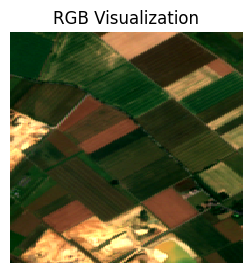

In [16]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3,3)
da_one_date.sel(band=['red', 'green', 'blue']).plot.imshow(
    ax=ax,
    robust=True)
ax.set_title('RGB Visualization')
ax.set_axis_off()
plt.show()

## Visualize for all dates

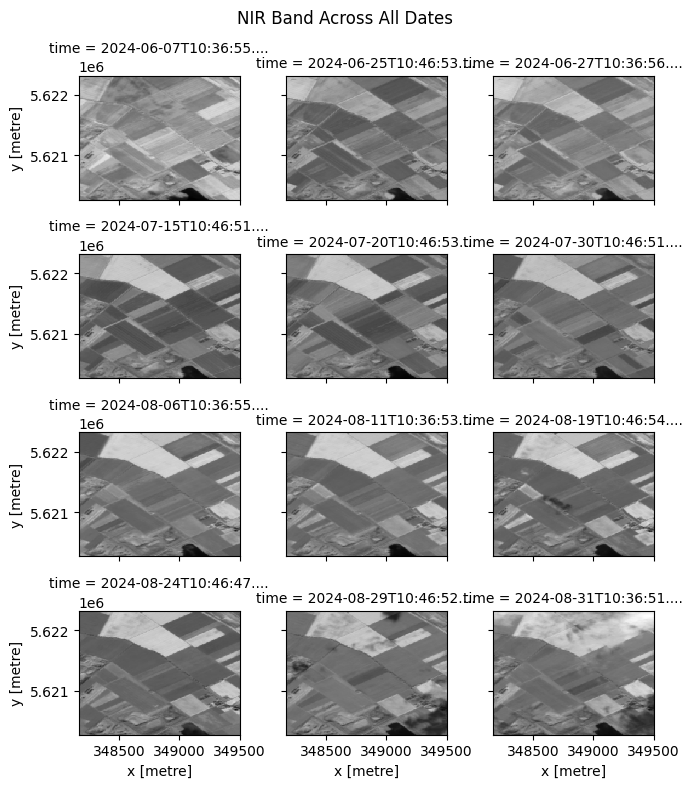

In [17]:
facet = ds['nir'].plot.imshow(
    col='time',
    col_wrap=3,
    cmap='Greys_r',
    add_colorbar=False,
    size=2,
    aspect=1
)

plt.suptitle('NIR Band Across All Dates', fontsize=12)
plt.tight_layout()
plt.show()

# Create NDVI band for each date

In [18]:
ds['ndvi'] = (ds['nir'] - ds['red']) / (ds['nir'] + ds['red'])
ds

<xarray.Dataset> Size: 6MB
Dimensions:      (y: 205, x: 133, time: 12)
Coordinates:
  * y            (y) float64 2kB 5.622e+06 5.622e+06 ... 5.62e+06 5.62e+06
  * x            (x) float64 1kB 3.482e+05 3.482e+05 ... 3.495e+05 3.495e+05
    spatial_ref  int32 4B 32632
  * time         (time) datetime64[ns] 96B 2024-06-07T10:36:55.279000 ... 202...
Data variables:
    red          (time, y, x) uint16 654kB 1444 1426 1434 ... 2300 2350 2386
    green        (time, y, x) uint16 654kB 1862 1864 1886 ... 2136 2202 2236
    blue         (time, y, x) uint16 654kB 1506 1505 1502 ... 1902 1974 2036
    nir          (time, y, x) uint16 654kB 5600 5732 5708 ... 2814 2932 3000
    scl          (time, y, x) uint8 327kB 4 4 4 4 4 4 4 4 4 ... 7 7 7 7 7 7 7 7
    ndvi         (time, y, x) float64 3MB 0.59 0.6016 0.5984 ... 0.1102 0.114

<ipython-input-19-2c55e3465a1d>:1: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  num_times = ds.dims['time']


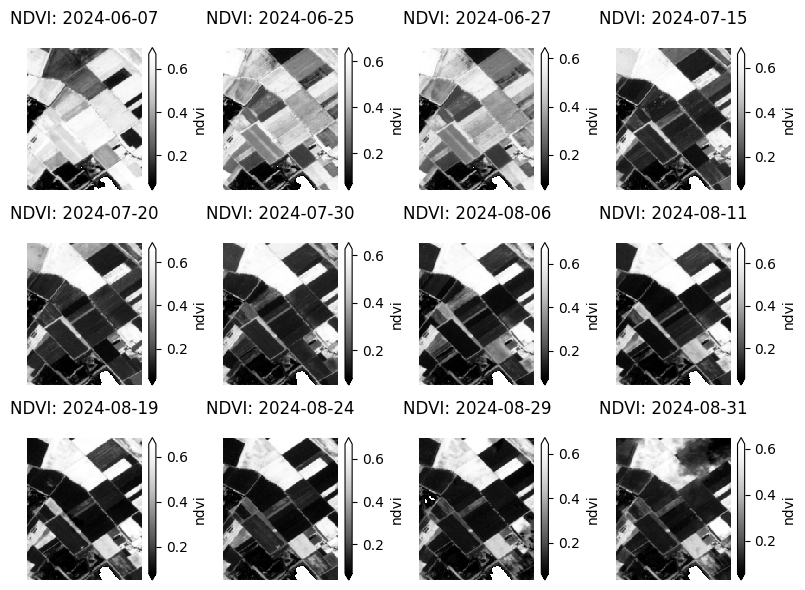

In [19]:
num_times = ds.dims['time']
ncols = 4
nrows = int(np.ceil(num_times / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
axes = axes.flatten()

time_values = ds.time.values

for i in range(num_times):
    da_one_date = ds.isel(time=i)
    ax = axes[i]

    date_str = np.datetime_as_string(time_values[i], unit='D')

    da_one_date.ndvi.plot.imshow(ax=ax, cmap='Greys_r', robust=True)
    ax.set_title(f'NDVI: {date_str}')
    ax.set_axis_off()


plt.tight_layout()
plt.show()


In [20]:
# ds['ndvi'].hvplot.image(x="x", y="y", groupby="time", cmap="YlGn", crs='EPSG:32631', tiles='ESRI')

# Create median composite

In [21]:
%%time
median = ds.median(dim='time')

CPU times: user 43.5 ms, sys: 2.62 ms, total: 46.1 ms
Wall time: 54 ms


In [22]:
median

<xarray.Dataset> Size: 1MB
Dimensions:      (y: 205, x: 133)
Coordinates:
  * y            (y) float64 2kB 5.622e+06 5.622e+06 ... 5.62e+06 5.62e+06
  * x            (x) float64 1kB 3.482e+05 3.482e+05 ... 3.495e+05 3.495e+05
    spatial_ref  int32 4B 32632
Data variables:
    red          (y, x) float64 218kB 2.252e+03 2.227e+03 ... 2.376e+03
    green        (y, x) float64 218kB 1.936e+03 1.942e+03 ... 2.029e+03
    blue         (y, x) float64 218kB 1.716e+03 1.686e+03 ... 1.796e+03
    nir          (y, x) float64 218kB 3.941e+03 3.945e+03 ... 3.844e+03 3.8e+03
    scl          (y, x) float64 218kB 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0
    ndvi         (y, x) float64 218kB 0.1649 0.169 0.169 ... 0.1508 0.1525

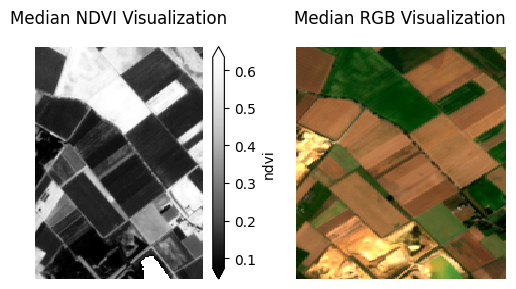

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(5, 3))

median.ndvi.plot.imshow(
    ax=axes[0],
    cmap='Greys_r',
    robust=True)
axes[0].set_title('Median NDVI Visualization')
axes[0].set_axis_off()

median.to_array('band').sel(band=['red', 'green', 'blue']).plot.imshow(
    ax=axes[1],
    robust=True)
axes[1].set_title('Median RGB Visualization')
axes[1].set_axis_off()

plt.tight_layout()
plt.show()

# Create monthly composites

In [24]:
monthly_median = ds.groupby('time.month').median(dim='time')
monthly_median

<xarray.Dataset> Size: 4MB
Dimensions:      (month: 3, y: 205, x: 133)
Coordinates:
  * y            (y) float64 2kB 5.622e+06 5.622e+06 ... 5.62e+06 5.62e+06
  * x            (x) float64 1kB 3.482e+05 3.482e+05 ... 3.495e+05 3.495e+05
    spatial_ref  int32 4B 32632
  * month        (month) int64 24B 6 7 8
Data variables:
    red          (month, y, x) float64 654kB 1.444e+03 1.426e+03 ... 2.802e+03
    green        (month, y, x) float64 654kB 1.862e+03 1.864e+03 ... 2.346e+03
    blue         (month, y, x) float64 654kB 1.506e+03 1.505e+03 ... 1.968e+03
    nir          (month, y, x) float64 654kB 6.268e+03 6.34e+03 ... 3.8e+03
    scl          (month, y, x) float64 654kB 4.0 4.0 4.0 4.0 ... 5.0 5.0 5.0 5.0
    ndvi         (month, y, x) float64 654kB 0.6211 0.6252 ... 0.1411 0.1445

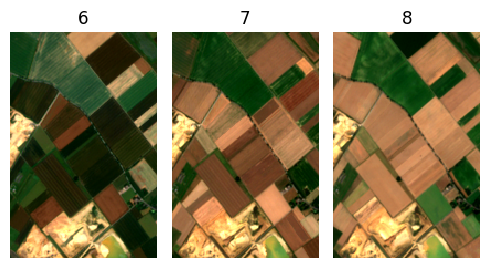

In [25]:
monthly_median_da = monthly_median.to_array('band')

fig, axes = plt.subplots(1, 3)
fig.set_size_inches(5, 3)

for index, ax in enumerate(axes.flat):
    month_da = monthly_median_da.isel(month=index)
    month_da.sel(band=['red', 'green', 'blue']).plot.imshow(
      ax=ax,
      robust=True)
    ax.set_title(f'{month_da.month.values}')
    ax.set_axis_off()
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

# Extract pixel values (zonal statistics)

In [26]:
field_geojson = '''
  {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [6.854703711886341, 50.72816177780557],
            [6.857021140475208, 50.72718381205174],
            [6.858823584933216, 50.72604282620386],
            [6.861741828341419, 50.727727128879735],
            [6.858051108736927, 50.730715258808],
            [6.854188727755481, 50.72865075302706],
            [6.854703711886341, 50.72816177780557]
          ]
        ]
      },
      "properties": {
        "color": "#ffc82d",
        "id": "1"
      }
    }
  ]
}
'''

# geojson_dict = json.loads(field_geojson)
# field = gpd.GeoDataFrame.from_features(geojson_dict["features"])

field = gpd.read_file(field_geojson)

field = field.set_crs("EPSG:4326")

field_utm = field.to_crs("EPSG:32632")

field_utm

,color,id,geometry
0,#ffc82d,1,"POLYGON ((348594.506 5621790.954, 348754.895 5..."


In [28]:
median_da = median.to_array('band')

In [29]:
field_utm['id'] = field_utm.id.astype(int)

field_utm_raster = make_geocube(
    vector_data=field_utm,
    measurements=['id'],
    like=median_da
)

field_utm_raster

<xarray.Dataset> Size: 221kB
Dimensions:      (y: 205, x: 133)
Coordinates:
  * y            (y) float64 2kB 5.622e+06 5.622e+06 ... 5.62e+06 5.62e+06
  * x            (x) float64 1kB 3.482e+05 3.482e+05 ... 3.495e+05 3.495e+05
    spatial_ref  int64 8B 0
Data variables:
    id           (y, x) float64 218kB nan nan nan nan nan ... nan nan nan nan

In [30]:
stats_df = zonal_stats(zones=field_utm_raster.id, values=median_da.sel(band="ndvi"))
stats_df

,zone,mean,max,min,sum,std,var,count
0,1.0,0.610154,0.647667,0.361074,829.199336,0.035971,0.001294,1359.0


# Save the median NDVI composite

In [31]:
## Example of clipping a raster
clipped = median_da.sel(band="ndvi").rio.clip(field_utm.geometry)

In [32]:
clipped

<xarray.DataArray (y: 51, x: 53)> Size: 22kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y            (y) float64 408B 5.622e+06 5.622e+06 ... 5.622e+06 5.622e+06
  * x            (x) float64 424B 3.486e+05 3.486e+05 ... 3.491e+05 3.491e+05
    band         <U4 16B 'ndvi'
    spatial_ref  int64 8B 0

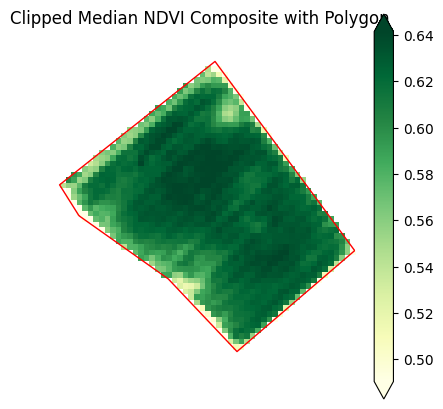

In [33]:
fig, ax = plt.subplots(figsize=(5, 5))
clipped.plot.imshow(ax=ax, cmap='YlGn', robust=True)
field_utm.plot(ax=ax, facecolor='none', edgecolor='red')
ax.set_title('Clipped Median NDVI Composite with Polygon')
ax.set_axis_off()
plt.show()

In [34]:
## Save
output_file = 'NDVI_median_clipped.tif'
output_folder = "."
output_path = os.path.join(output_folder, output_file)
clipped.rio.to_raster(output_path, driver='COG')
print(f'Wrote {output_file}')

Wrote NDVI_median_clipped.tif


# Read the saved raster

In [35]:
raster = rxr.open_rasterio(output_path, mask_and_scale=True)
raster

<xarray.DataArray (band: 1, y: 51, x: 53)> Size: 22kB
[2703 values with dtype=float64]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 424B 3.486e+05 3.486e+05 ... 3.491e+05 3.491e+05
  * y            (y) float64 408B 5.622e+06 5.622e+06 ... 5.622e+06 5.622e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area

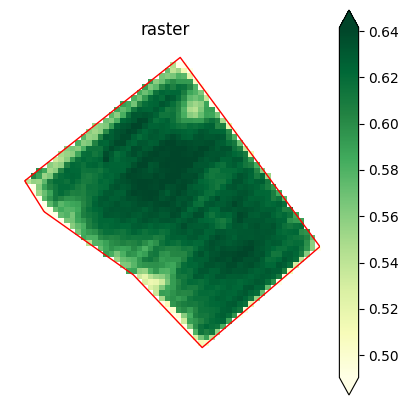

In [36]:
fig, ax = plt.subplots(figsize=(5, 5))
raster.squeeze().plot.imshow(ax=ax, cmap='YlGn', robust=True)
field_utm.plot(ax=ax, facecolor='none', edgecolor='red')
ax.set_title('raster')
ax.set_axis_off()
plt.show()